In [1]:
import numpy as np
import pandas as pd
import math
from math import log

In [2]:
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [4]:
datasets, labels = create_data()

In [5]:
train_data = pd.DataFrame(datasets, columns=labels)

In [6]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [7]:
#信息熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p / data_length) * log(p / data_length, 2)
                for p in label_count.values()])
    return ent

In [8]:
#条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p) / data_length) * calc_ent(p)
                    for p in feature_sets.values()])
    return cond_ent

In [9]:
calc_ent(datasets)

0.9709505944546686

In [10]:
#信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent
def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) 的信息增益为： {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [11]:
info_gain_train(np.array(datasets))

特征(年龄) 的信息增益为： 0.083
特征(有工作) 的信息增益为： 0.324
特征(有自己的房子) 的信息增益为： 0.420
特征(信贷情况) 的信息增益为： 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

In [13]:
#利用ID3算法生成决策树

# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {
            'label:': self.label,
            'feature': self.feature,
            'tree': self.tree
        }

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)

#DTree 类表示整个决策树模型
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                    for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                        for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_
#train 方法用于训练决策树
    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :
                                               -1], train_data.iloc[:,
                                                                    -1], train_data.columns[:
                                                                                            -1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(
            root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree
#fit 方法是 train 方法的封装，用于训练决策树并返回整个模型
    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree
#predict 方法用于对给定的测试数据进行预测，接受一个测试数据集并返回预测结果。
    def predict(self, X_test):
        return self._tree.predict(X_test)

In [14]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [15]:
tree

{'label:': None, 'feature': 2, 'tree': {'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}

In [17]:
dt.predict(['老年', '否', '否', '一般'])

'否'

In [18]:
#sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [19]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1],iris.feature_names[0:2]


X, y,feature_name= create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)

clf.score(X_test, y_test)

0.9333333333333333

[Text(0.5, 0.9, 'x[1] <= 2.95\ngini = 0.5\nsamples = 70\nvalue = [36, 34]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 26\nvalue = [0, 26]'),
 Text(0.6666666666666666, 0.7, 'x[0] <= 5.85\ngini = 0.298\nsamples = 44\nvalue = [36, 8]'),
 Text(0.5, 0.5, 'x[1] <= 3.05\ngini = 0.1\nsamples = 38\nvalue = [36, 2]'),
 Text(0.3333333333333333, 0.3, 'x[0] <= 5.2\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.0\nsamples = 30\nvalue = [30, 0]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

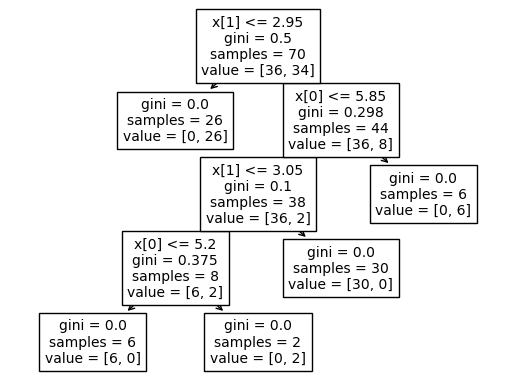

In [21]:
tree.plot_tree(clf) 

In [22]:
#导出树
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

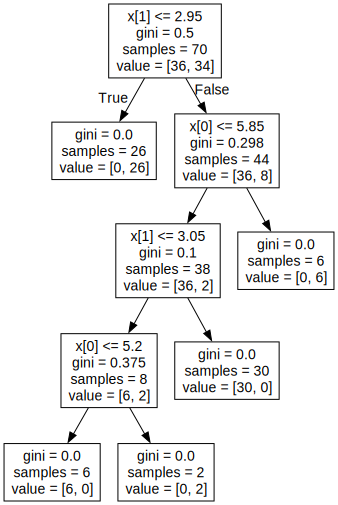

In [23]:
graphviz.Source(dot_graph)

In [29]:
#以文本格式导出树
from sklearn.tree import export_text

In [33]:
r = export_text(clf)

In [34]:
print(r)

|--- feature_1 <= 2.95
|   |--- class: 1.0
|--- feature_1 >  2.95
|   |--- feature_0 <= 5.85
|   |   |--- feature_1 <= 3.05
|   |   |   |--- feature_0 <= 5.20
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_0 >  5.20
|   |   |   |   |--- class: 1.0
|   |   |--- feature_1 >  3.05
|   |   |   |--- class: 0.0
|   |--- feature_0 >  5.85
|   |   |--- class: 1.0



In [35]:
#决策树回归
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [36]:
# 创建一个随机数据集
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

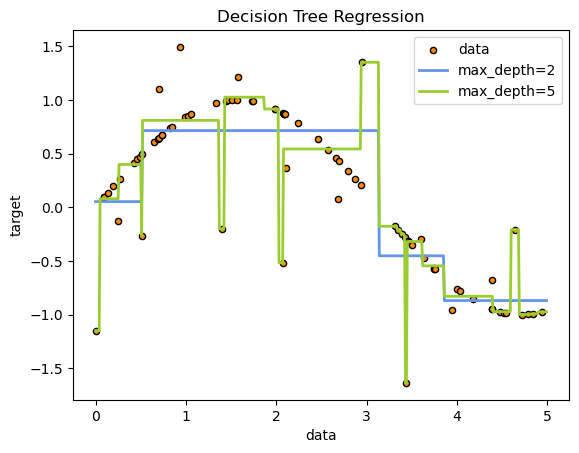

In [37]:
# 拟合回归模型
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# 预测
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# 绘制结果图像
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [38]:
#决策树调参
# 导入库
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [39]:
# 导入数据集
X = datasets.load_iris()  # 以全部字典形式返回,有data,target,target_names三个键
data = X.data
target = X.target
name = X.target_names
x, y = datasets.load_iris(return_X_y=True)  # 能一次性取前2个
print(x.shape, y.shape)

(150, 4) (150,)


In [40]:
# 数据分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=100)

In [41]:
# 用GridSearchCV寻找最优参数（字典）
param = {
    'criterion': ['gini'],
    'max_depth': [30, 50, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=6)
grid.fit(x_train, y_train)
print('最优分类器:', grid.best_params_, '最优分数:', grid.best_score_)  # 得到最优的参数和分值

最优分类器: {'criterion': 'gini', 'max_depth': 100, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2} 最优分数: 0.9416666666666665
